# Crane optimization
Here is some text explaining the problem at hand.

And maybe a figure.

And here is some math:
$$
e^{i \pi} + 1 = 0
$$

In [648]:
# Enable interactive plot
# %matplotlib notebook
%matplotlib inline

In [649]:
# Imports:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
import casadi as cs
plt.style.use('seaborn-pastel')

Explain dynamics briefly. Show the equations...

In [650]:
r = cs.MX.sym('r')
theta = cs.MX.sym('theta')
r_dot = cs.MX.sym('r_dot')
theta_dot = cs.MX.sym('theta_dot')
x = cs.vertcat(r, theta, r_dot, theta_dot)

u = cs.MX.sym('F')

m_1 = 5.0  # mass of cart
m_2 = 1.0  # mass of pendulum
l = 1.0    # length of pendulum
g = 9.81   # gravity

M_inv = cs.MX(2,2)
M_inv[0,0] = m_2 * l**2
M_inv[0,1] = - m_2 * l * cs.cos(theta)
M_inv[1,0] = - m_2 * l * cs.cos(theta)
M_inv[1,1] = m_1 + m_2
M_inv = M_inv / ((m_1 + m_2) * m_2 * l**2 - m_2**2 * l**2 * cs.cos(theta)**2)

h = cs.MX(2,1)
h[0,0] = -m_2 * l * theta_dot**2 * cs.sin(theta)
h[1,0] = m_2 * l * g * cs.sin(theta)

x_dot = cs.vertcat(x[2:], cs.mtimes(M_inv, (cs.vertcat(u, 0) - h)))
f = cs.Function('f', [x, u], [x_dot])

Explain discretization briefly? RK4

In [651]:
def integrate_RK4(x_k, u_k, f, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k + dt * k1 / 2.0, u_k)
    k3 = f(x_k + dt * k2 / 2.0, u_k)
    k4 = f(x_k + dt * k3, u_k)
    return x_k + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

dt = 0.05
x_0 = np.array([-0.5, 0.0, 0.0, 0.0])

f_d = cs.Function('f', [x, u], [integrate_RK4(x, u, f, dt)])

Optimization:
Need to show problem we are formulating and explain NLPs briefly

In [652]:
# Number of control segments
N = 80

r_0 = 0.5

def optimize_crane(N, x_0, r_0, use_u_cost=False, use_term_constraint=False, use_u_constraint=False, u_max=None, use_theta_constraint=False, theta_max=None):
    R_r = 100
    R_theta = 100
    R_r_dot = 1
    R_theta_dot = 1
    R_u = 0.1 if use_u_cost else 0

    # Objective function and constraints
    J_k = cs.Function('J_k', [x, u], [R_r*(x[0] - r_0)**2 + R_theta*x[1]**2 + R_r_dot*x[2]**2 + R_theta_dot*x[3]**2 + R_u*u**2])

    # Start with an empty NLP
    w = []
    w0 = [] # TODO set one single time instead
    lbw = []
    ubw = []
    J = 0
    g = []
    lbg = []
    ubg = []

    # Formulate the NLP
    X_k = cs.MX(x_0)
    for k in range(N):
        # Control variable at step k:
        U_k = cs.MX.sym('U_' + str(k))
        w += [U_k]
        w0 += [0]
        
        if use_u_constraint:
            lbw += [-u_max]
            ubw += [u_max]
        else:
            lbw += [-cs.inf]
            ubw += [cs.inf]

        # Integrate till the end of the interval:
        X_k = f_d(X_k, U_k)
        J += dt * J_k(X_k, U_k)

        if use_theta_constraint:
            g += [X_k[1]]
            lbg += [-theta_max]
            ubg += [theta_max]

    if use_term_constraint:
        g += [X_k[0] - r_0]
        lbg += [0.0]
        ubg += [0.0]

        g += [X_k[1:]]
        lbg += [0.0, 0.0, 0.0]
        ubg += [0.0, 0.0, 0.0]

    # Create an NLP solver
    nlp = {'f': J, 'x': cs.vertcat(*w), 'g': cs.vertcat(*g)}
    opts = {'ipopt.print_level':0, 'print_time':0}
    solver = cs.nlpsol('solver', 'ipopt', nlp, opts)

    # Solve the NLP
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    u_sol = sol['x']

    return u_sol

Simulation:

In [653]:
N_sim = 1000
dt_sim = 0.005

def simulate_crane(x_0, u):
    k_u = int(dt/dt_sim)
    x_sim = np.zeros((N_sim+1,4))
    x_sim[0,:] = x_0
    u_sim = np.zeros(N_sim)
    for k in range(N_sim):
        if k < k_u * N: u_sim[k] = u[int(k/k_u)]
        x_sim[k+1] = np.array(integrate_RK4(x_sim[k], u_sim[k], f, dt_sim)).squeeze()
    return x_sim, u_sim

Plots:

In [654]:
def plot_results(x_sim, u_sim):
    t = np.array([dt_sim*i for i in range(N_sim)])
    
    plt.figure()
    plt.step(t, u_sim, where='post')
    plt.title('Control input')

    fig, ax = plt.subplots(2,2)

    ax[0,0].plot(t, x_sim[:N_sim,0])
    ax[0,0].set_title(r'$x$')
    ax[0,1].plot(t, x_sim[:N_sim,1])
    ax[0,1].set_title(r'$\theta$')

    ax[1,0].plot(t, x_sim[:N_sim,2])
    ax[1,0].set_title(r'$\dot{x}$')
    ax[1,1].plot(t, x_sim[:N_sim,3])
    ax[1,1].set_title(r'$\dot{\theta}$')

    plt.show()

Animation:

In [655]:
from IPython.display import HTML

mpl.rcParams['lines.linewidth'] = 2

def show_animation():
    skips = 10
    frames = int(N_sim / skips)
    delay = skips*dt_sim*1e3

    rect_height = 0.2
    beam_height = 0.075

    fig, ax = plt.subplots()

    line_1, = ax.plot([-1.2,1.2], [0,0], 'k--', lw=1.0)
    rect_1 = ax.add_patch(Rectangle((0 - 1, 0 - 0.5*beam_height), 2, beam_height, facecolor='darkslategray', edgecolor='k', lw=2))
    rect_2 = ax.add_patch(Rectangle((x_sim[0,0] - 0.2, 0.0 - 0.5*rect_height), 0.4, rect_height, facecolor='teal', edgecolor='k', lw=2))

    x_pendulum = x_sim[0,0] + l * np.sin(x_sim[0,1])
    y_pendulum = -l * np.cos(x_sim[0,1])
    line_2, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], '-o', c='k', lw=3, ms=6)
    point_1 = ax.scatter(x_pendulum, y_pendulum, s=500, facecolors='darkorange', edgecolors='k', lw=2)

    line_3, = ax.plot([-0.5, -0.5], [-1,0], 'k--', lw=1.0)
    line_3, = ax.plot([0.5, 0.5], [-1,0], 'k--', lw=1.0)

    plt.axis('equal')
    plt.xlim([-1, 1])
    plt.ylim([-1.5, 0.5])

    def animate(i):
        rect_2.set_xy([x_sim[skips*i,0] - 0.2, 0.0 - 0.5*rect_height])
        
        x_pendulum = x_sim[skips*i,0] + l * np.sin(x_sim[skips*i,1])
        y_pendulum = -l * np.cos(x_sim[skips*i,1])
        
        point_1.set_offsets([x_pendulum, y_pendulum])
        line_2.set_data([x_sim[skips*i,0], x_pendulum], [0, y_pendulum])
        
        return line_2, point_1, rect_2

    return animation.FuncAnimation(fig, animate, frames=frames, interval=delay, blit=True)

First we do the most simple we can do: just penalize deviation from desired state.
Here we could also do tuning... Not just give them the answers...

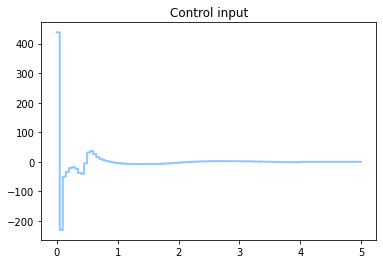

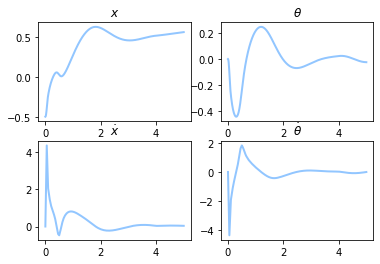

In [656]:
u_sol = optimize_crane(N, x_0, r_0)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)

We can run this to show the animation in HTML afterwards (press play button):

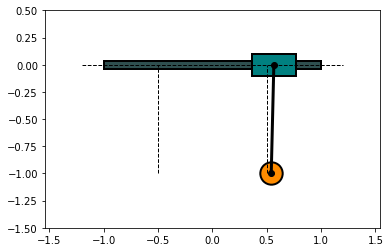

In [657]:
HTML(show_animation().to_jshtml())

We see that the control input is very high and the resulting motion is jerky and not suited for a crane...
We therefore add a penalty to large control inputs:

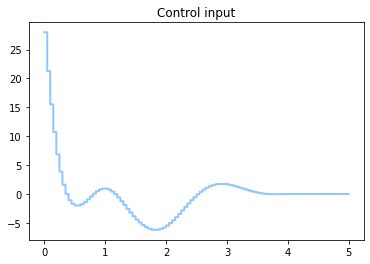

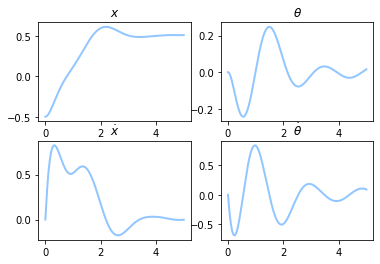

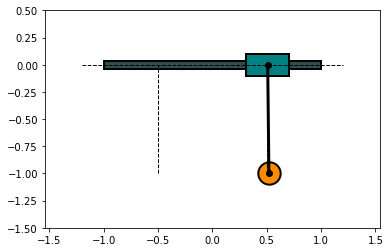

In [658]:
u_sol = optimize_crane(N, x_0, r_0, use_u_cost=True)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

That looks much smoother. But it doesnt hit our target exactly, it continues to wiggle...
We add a terminal constraint:

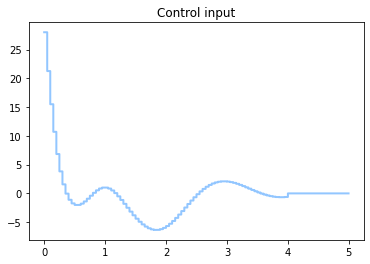

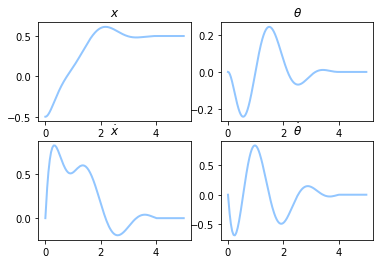

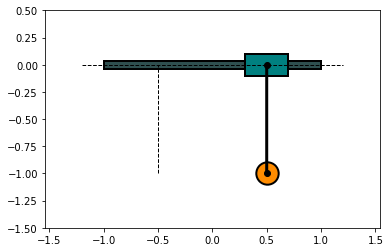

In [659]:
u_sol = optimize_crane(N, x_0, r_0, use_u_cost=True, use_term_constraint=True)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

Now we are getting somewhere! 
Ok, but what if we have a maximum force we can push the cart with? One of the main reasons why optimization is so popular in robotics applications is that such constraints can be seamlessly added to the optimization problem!

We add input constraint such that we can not push with more than say 3 N of force:

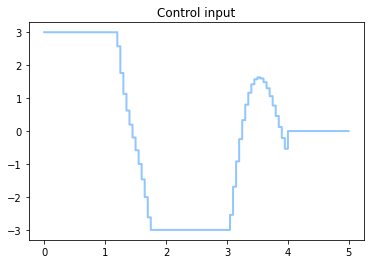

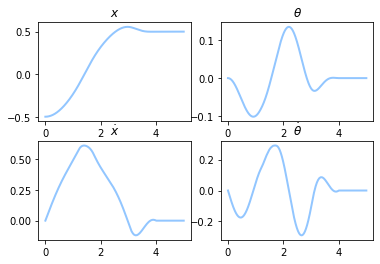

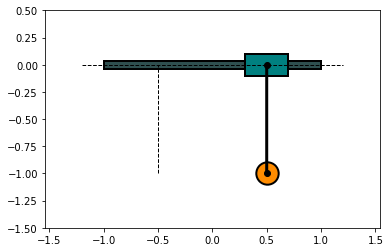

In [660]:
u_max = 3.0
u_sol = optimize_crane(N, x_0, r_0, use_u_cost=True, use_term_constraint=True, use_u_constraint=True, u_max=u_max)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

As we see from the plot of the control input we do not violate the +- 3N constraint, very nice.

Now you may ask, can we do the same with the state variables? Yes, we can! What if we want to limit the angle $\theta$ to be below e.g. 0.05?

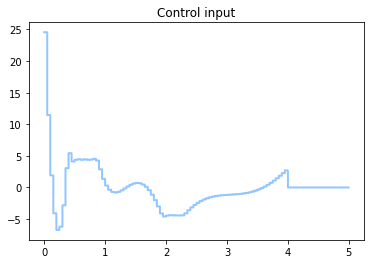

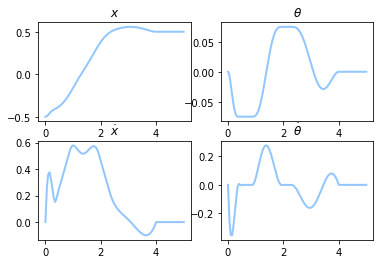

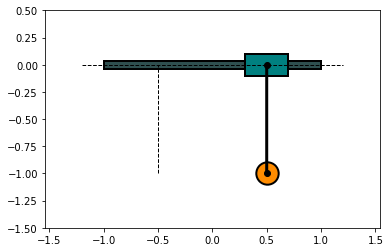

In [661]:
theta_max = 0.075
u_sol = optimize_crane(N, x_0, r_0, use_u_cost=True, use_term_constraint=True, use_theta_constraint=True, theta_max=theta_max)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

Nice!

From here there is also more to explore, like more complex constraints or trajectory tracking...